# ✨ Custom Word2Vec Embedding Pipeline – Overview

This document outlines the custom Word2Vec embedding generation pipeline applied to IMDB review data, used to support downstream deep learning models for sentiment classification.

---

## 🧭 Step-by-Step Process

### #1. 📦 Imports  
**Goal**: Bring in necessary libraries for text processing, embedding generation, and data storage.

Includes:
- `pandas`, `numpy` – for data loading and manipulation  
- `gensim` – to train Word2Vec embeddings  
- `keras.preprocessing` – for tokenization and padding  
- `pickle`, `os` – for saving tokenizer and model objects  

---

### #2. ⚙️ Constants  
**Goal**: Define global parameters for the embedding process.  
Includes settings like:
- `EMBEDDING_DIM` (e.g., 100)  
- `MAX_LEN` for padding review sequences  
- Paths for saving the tokenizer and Word2Vec model  

---

### #3. 📂 Load Cleaned Data  
**Goal**: Read in the preprocessed `train`, `test`, and `unlabeled` review datasets from CSV files.  
All files are assumed to be cleaned using previous preprocessing pipelines.

---

### #4. 🧹 Prepare Corpus for Word2Vec  
**Goal**: Build a unified tokenized corpus for training embeddings.  
- Concatenate all `clean_review` texts from `train`, `test`, and `unlabeled` datasets.  
- Tokenize each review into a list of words (`str.split()`).  
- Corpus is now a list of tokenized reviews ready for training.

---

### #5. 🧠 Train Word2Vec Model  
**Goal**: Generate dense word embeddings using the cleaned corpus.  
- Trains a `Word2Vec` model using skip-gram/CBOW on the tokenized reviews.  
- Saves the trained model for later embedding lookup.  

---

### #6. 🔤 Tokenize and Pad Sequences  
**Goal**: Prepare reviews for neural network input.  
- Create a **Tokenizer** object and fit on all cleaned text.  
- Convert text to **integer sequences**.  
- **Pad sequences** to a fixed length (`MAX_LEN`) using `post` padding.  
- Save the tokenizer object for reuse during inference.  

---

### #7. 🧱 Build Embedding Matrix  
**Goal**: Align tokenizer word index with Word2Vec vectors.  
- Create a matrix where:  
  - **Rows** = vocabulary size  
  - **Columns** = embedding dimensions (100)  
- Each row represents the Word2Vec vector of the corresponding word in the tokenizer vocabulary.  
- Words not found in the Word2Vec vocabulary are initialized with **random normal values**.

---

### #8. 🚀 Run Pipeline  
**Goal**: Execute the full pipeline in one go.  
- Loads the cleaned data  
- Prepares corpus  
- Trains Word2Vec  
- Tokenizes and pads reviews  
- Builds embedding matrix  
- Saves final artifacts:  
  - `padded_sequences.npy`  
  - `embedding_matrix.npy`  
  - `tokenizer.pkl`  
  - `word2vec_model.bin`

---

### #9. ✅ Final Output  
**Shapes printed for verification**:
- `padded_sequences`: `[n_samples, max_len]`  
- `embedding_matrix`: `[vocab_size, embedding_dim]`  

Artifacts are saved in the `outputs/` directory and are ready to be plugged into downstream LSTM or CNN models for training.

---

🔹 Training Word2Vec...
🔹 Tokenizing and padding...
🔹 Building embedding matrix...
✅ Padded shape: (100000, 300)
✅ Embedding matrix shape: (329952, 100)
📊 Visualizing word embeddings for synonyms and antonyms...


/tmp/ipykernel_35/3135381376.py:122: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3135381376.py:123: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.savefig("outputs/embedding_plot.png")  # Save as file
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


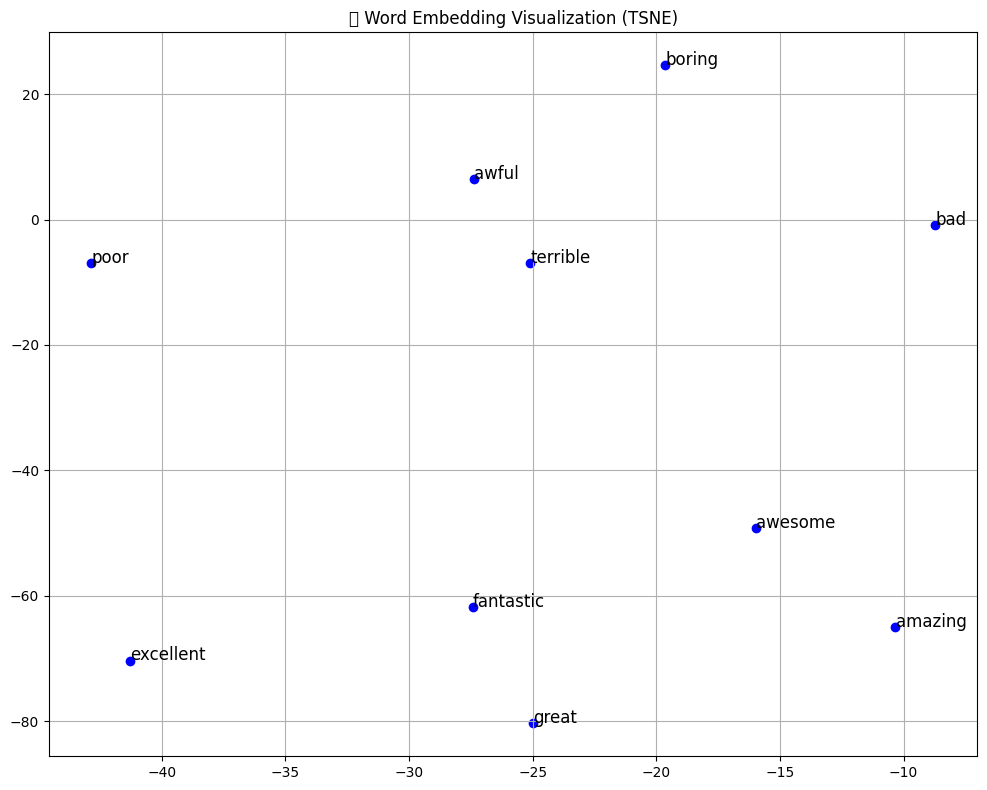

In [9]:
# -------------------------------
# 1. All imports
# -------------------------------
import os
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle

# -------------------------------
# 2. Constants
# -------------------------------
EMBEDDING_DIM = 100
MAX_LEN = 300
OOV_TOKEN = "<OOV>"
TOKENIZER_PATH = "outputs/tokenizer.pkl"
W2V_MODEL_PATH = "outputs/word2vec_model.bin"

os.makedirs('outputs', exist_ok=True)

# -------------------------------
# 3. Load preprocessed data
# -------------------------------
def load_cleaned_data():
    train = pd.read_csv("/kaggle/input/popcorn-dataset-preprocessed/preprocessed/train_cleaned.csv")
    test = pd.read_csv("/kaggle/input/popcorn-dataset-preprocessed/preprocessed/test_cleaned.csv")
    unlabeled = pd.read_csv("/kaggle/input/popcorn-dataset-preprocessed/preprocessed/unlabeled_cleaned.csv")
    return train, test, unlabeled

# -------------------------------
# 4. Prepare corpus for Word2Vec
# -------------------------------
def get_corpus(train, test, unlabeled):
    all_reviews = pd.concat([
        train['clean_review'], 
        test['clean_review'], 
        unlabeled['clean_review']
    ]).dropna().tolist()
    
    # Split into list of words
    tokenized_reviews = [review.split() for review in all_reviews]
    return tokenized_reviews

# -------------------------------
# 5. Train Word2Vec
# -------------------------------
def train_word2vec(sentences, embedding_dim=EMBEDDING_DIM):
    model = Word2Vec(
        sentences=sentences, 
        vector_size=embedding_dim, 
        window=5, 
        min_count=2,
        workers=4
    )
    model.save(W2V_MODEL_PATH)
    return model

# -------------------------------
# 6. Tokenize and pad sequences
# -------------------------------
def tokenize_and_pad(train_texts, max_len=MAX_LEN):
    tokenizer = Tokenizer(oov_token=OOV_TOKEN)
    tokenizer.fit_on_texts(train_texts)
    
    sequences = tokenizer.texts_to_sequences(train_texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    
    # Save tokenizer
    with open(TOKENIZER_PATH, "wb") as f:
        pickle.dump(tokenizer, f)
    
    return padded, tokenizer

# -------------------------------
# 7. Build embedding matrix
# -------------------------------
def build_embedding_matrix(tokenizer, word2vec_model, embedding_dim=EMBEDDING_DIM):
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_index.items():
        if word in word2vec_model.wv:
            matrix[i] = word2vec_model.wv[word]
        else:
            matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
    
    return matrix

# -------------------------------
# 8. Visualize embeddings
# -------------------------------
def visualize_embeddings(tokenizer, embedding_matrix, words):
    word_indices = []
    labels = []

    for word in words:
        idx = tokenizer.word_index.get(word)
        if idx and idx < embedding_matrix.shape[0]:
            word_indices.append(idx)
            labels.append(word)

    vectors = np.array([embedding_matrix[idx] for idx in word_indices])

    # Reduce to 2D using t-SNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    reduced = tsne.fit_transform(vectors)

    # Plot
    plt.figure(figsize=(10, 8))
    for i, word in enumerate(labels):
        x, y = reduced[i, 0], reduced[i, 1]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, word, fontsize=12)
    plt.title('🔍 Word Embedding Visualization (TSNE)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("outputs/embedding_plot.png")  # Save as file
    plt.show()

# -------------------------------
# 9. Run the Pipeline
# -------------------------------
def run_pipeline():
    train_df, test_df, unlabeled_df = load_cleaned_data()
    corpus = get_corpus(train_df, test_df, unlabeled_df)

    print("🔹 Training Word2Vec...")
    w2v_model = train_word2vec(corpus)

    print("🔹 Tokenizing and padding...")
    all_cleaned_texts = train_df['clean_review'].tolist() + test_df['clean_review'].tolist() + unlabeled_df['clean_review'].tolist()
    padded_sequences, tokenizer = tokenize_and_pad(all_cleaned_texts)

    print("🔹 Building embedding matrix...")
    embedding_matrix = build_embedding_matrix(tokenizer, w2v_model)

    print(f"✅ Padded shape: {padded_sequences.shape}")
    print(f"✅ Embedding matrix shape: {embedding_matrix.shape}")

    np.save("outputs/padded_sequences.npy", padded_sequences)
    np.save("outputs/embedding_matrix.npy", embedding_matrix)

    # 📊 Add embedding visualization
    words_to_compare = [
        # Synonyms
        'excellent', 'amazing', 'awesome', 'great', 'fantastic',
        # Antonyms
        'boring', 'bad', 'terrible', 'awful', 'poor'
    ]
    print("📊 Visualizing word embeddings for synonyms and antonyms...")
    visualize_embeddings(tokenizer, embedding_matrix, words_to_compare)

    return padded_sequences, embedding_matrix

# -------------------------------
# 10. Execute
# -------------------------------
padded_sequences, embedding_matrix = run_pipeline()


In [10]:
import shutil

# Compress /kaggle/working/outputs to outputs.zip
shutil.make_archive("/kaggle/working/outputs", 'zip', "/kaggle/working/outputs")

'/kaggle/working/outputs.zip'